## Download dataset

In [1]:
!wget 'https://docs.google.com/uc?export=download&id=1sOuPFgVikmQ1c8f-2ubUH7L7buVE7nlS&confirm=t' -O data.zip  --quiet

!unzip data.zip


Archive:  data.zip
   creating: Dataset/
  inflating: Dataset/Test.json       
  inflating: Dataset/Train.json      
  inflating: Dataset/Validation.json  
  inflating: Dataset/readme_pquad_en.txt  
  inflating: Dataset/readme_pquad_fa.txt  
   creating: Dataset/xray_dataset_covid19/
   creating: Dataset/xray_dataset_covid19/test/
   creating: Dataset/xray_dataset_covid19/test/COVID/
  inflating: Dataset/xray_dataset_covid19/test/COVID/ryct.2020200034.fig2.jpeg  
  inflating: Dataset/xray_dataset_covid19/test/COVID/ryct.2020200034.fig5-day0.jpeg  
  inflating: Dataset/xray_dataset_covid19/test/COVID/ryct.2020200034.fig5-day4.jpeg  
  inflating: Dataset/xray_dataset_covid19/test/COVID/ryct.2020200034.fig5-day7.jpeg  
  inflating: Dataset/xray_dataset_covid19/test/COVID/SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg  
  inflating: Dataset/xray_dataset_covid19/test/COVID/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg  
  inflating: Dataset/xray_dataset_covid19/test/COVID/SARS-10.1

## import libraries

In [2]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.utils.data import ConcatDataset
import numpy as np


from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Define the root folder of the dataset
root_folder = '/content/Dataset/xray_dataset_covid19/train'

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create an instance of the ImageFolder dataset
dataset = ImageFolder(root=root_folder, transform=transform)


Image shape: torch.Size([3, 150, 150]), Class Label: COVID 0,
All data count 148


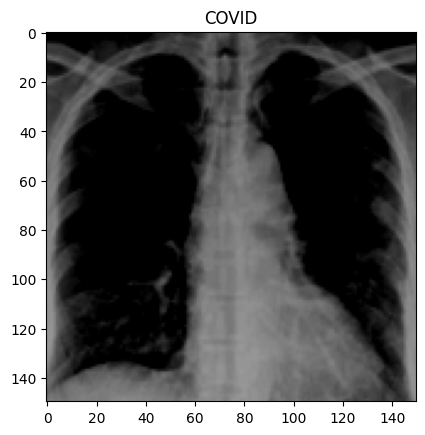

In [4]:
image, class_index = dataset[2]
class_label = dataset.classes[class_index]
print(f"Image shape: {image.shape}, Class Label: {class_label} {class_index},\nAll data count {len(dataset)}")

image = image.permute(1, 2, 0).numpy()

# Visualize the image using Matplotlib
plt.imshow(image)
plt.title(class_label)
# plt.axis('off')
plt.show()

## CNN implementation

In [17]:
class CNN(nn.Module):
    def __init__(self, num_classes,conv_feat_num=[3,64,64,128,128,256,256]):
        super(CNN, self).__init__()

        conv_f_n = conv_feat_num

        conv_l=[]
        for i in range(1,len(conv_f_n)):
          conv_l.extend([nn.Conv2d(conv_f_n[i-1], conv_f_n[i], kernel_size=3,padding=1, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(conv_f_n[i]),
            nn.ReLU(),
            nn.Dropout(0.2)])

        self.features = nn.Sequential(
            *conv_l
        )
        self.flatten = nn.Flatten()
        in_feat=((150//(2**(len(conv_f_n)-1)))**2)*conv_f_n[-1]
        self.fc = nn.Sequential(
            nn.Linear(in_feat, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x



In [18]:
num_classes = 2  # Number of classes for classification task
model = CNN(num_classes)
model.to(device)
print(model)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Dropout(p=0.2, inplace=False)
    (15): Conv2d(128, 128, kernel_size=(3, 3), stride=

## Data augmentation

In [7]:
aug_trans1=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(p=1.),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
aug_trans2=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomRotation([90,90]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
aug_trans3=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomRotation([180,180]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
aug_trans4=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomRotation([270,270]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

a1_dataset = ImageFolder(root=root_folder, transform=aug_trans1)
a2_dataset = ImageFolder(root=root_folder, transform=aug_trans2)
a3_dataset = ImageFolder(root=root_folder, transform=aug_trans3)
a4_dataset = ImageFolder(root=root_folder, transform=aug_trans4)

# Concatenate the initial dataset with itself
combined_dataset = ConcatDataset([dataset, a1_dataset,a2_dataset,a3_dataset,a4_dataset])


In [8]:
# Split the combined dataset into training and validation sets
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(combined_dataset, [train_size, val_size])

# Define the dataloaders for training and validation
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Training Model

In [9]:
def train(model, train_loader, val_loader, num_epochs=10, lr=0.0001):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  losses = []
  accuracies = []
  val_losses = []
  val_accuracies = []
  # Train the model
  for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    val_loss = 0.0
    val_acc = 0.0
    for i, (images, labels) in enumerate(train_loader):
      # Forward pass
      images=images.to(device)
      labels=labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs.data, 1)
    acc = (predicted == labels).sum().item() / labels.size(0)
    accuracies.append(acc)
    losses.append(train_loss)

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
      for images, labels in val_loader:
        labels=labels.to(device)
        images=images.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
      total = labels.size(0)
      correct = (predicted == labels).sum().item()
      val_acc += correct / total
      val_accuracies.append(val_acc)
      val_losses.append(val_loss)


    print('Epoch [{}/{}],Loss:{:.4f},Validation Loss:{:.4f},Accuracy:{:.2f},Validation Accuracy:{:.2f}'.format(
      epoch+1, num_epochs, train_loss, val_loss, acc ,val_acc))
  return model, accuracies, val_accuracies, losses, val_losses

In [10]:
num_epochs = 10
_, train_accuracy, val_accuracy, train_losses, val_losses=train(model,train_dataloader,val_dataloader,10,0.0008)



 10%|█         | 1/10 [00:44<06:36, 44.02s/it]

Epoch [1/10],Loss:8.7478,Validation Loss:11.0198,Accuracy:0.94,Validation Accuracy:0.30


 20%|██        | 2/10 [01:10<04:31, 33.98s/it]

Epoch [2/10],Loss:2.8059,Validation Loss:14.0336,Accuracy:0.94,Validation Accuracy:0.30


 30%|███       | 3/10 [01:38<03:36, 30.97s/it]

Epoch [3/10],Loss:1.6183,Validation Loss:12.4054,Accuracy:0.94,Validation Accuracy:0.30


 40%|████      | 4/10 [02:07<03:01, 30.27s/it]

Epoch [4/10],Loss:1.1925,Validation Loss:10.6328,Accuracy:1.00,Validation Accuracy:0.45


 50%|█████     | 5/10 [02:36<02:28, 29.71s/it]

Epoch [5/10],Loss:0.9553,Validation Loss:14.8456,Accuracy:1.00,Validation Accuracy:0.30


 60%|██████    | 6/10 [03:03<01:55, 28.80s/it]

Epoch [6/10],Loss:0.9873,Validation Loss:5.0080,Accuracy:1.00,Validation Accuracy:0.60


 70%|███████   | 7/10 [03:30<01:24, 28.28s/it]

Epoch [7/10],Loss:0.9936,Validation Loss:0.5244,Accuracy:1.00,Validation Accuracy:1.00


 80%|████████  | 8/10 [03:57<00:55, 27.83s/it]

Epoch [8/10],Loss:1.2188,Validation Loss:4.0081,Accuracy:1.00,Validation Accuracy:0.80


 90%|█████████ | 9/10 [04:24<00:27, 27.62s/it]

Epoch [9/10],Loss:0.4988,Validation Loss:1.1298,Accuracy:1.00,Validation Accuracy:1.00


100%|██████████| 10/10 [04:52<00:00, 29.21s/it]

Epoch [10/10],Loss:0.3756,Validation Loss:1.4382,Accuracy:1.00,Validation Accuracy:0.95


### Visualize the diagrams

In [11]:
def visualize_l_a(train_accuracy, val_accuracy, train_losses, val_losses):
  # Plot loss curves
  plt.figure(figsize=(10, 5))
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Val Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.show()

  # Plot accuracy curves
  plt.figure(figsize=(10, 5))
  plt.plot(train_accuracy, label='Train Accuracy')
  plt.plot(val_accuracy, label='Val Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.show()

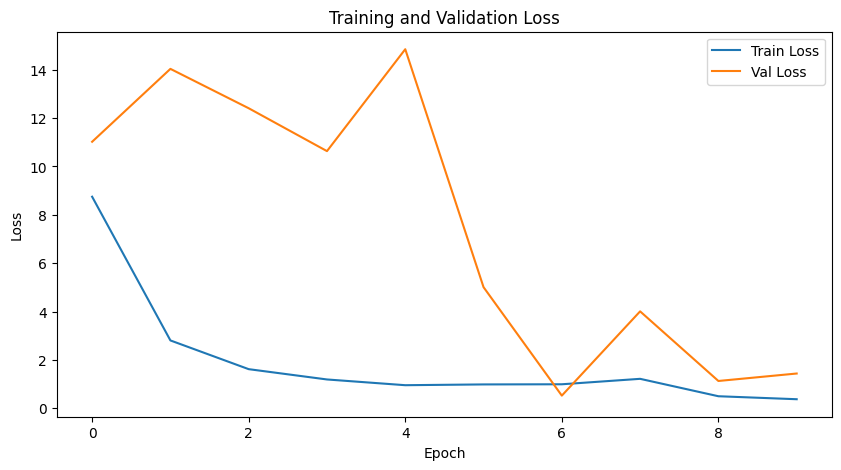

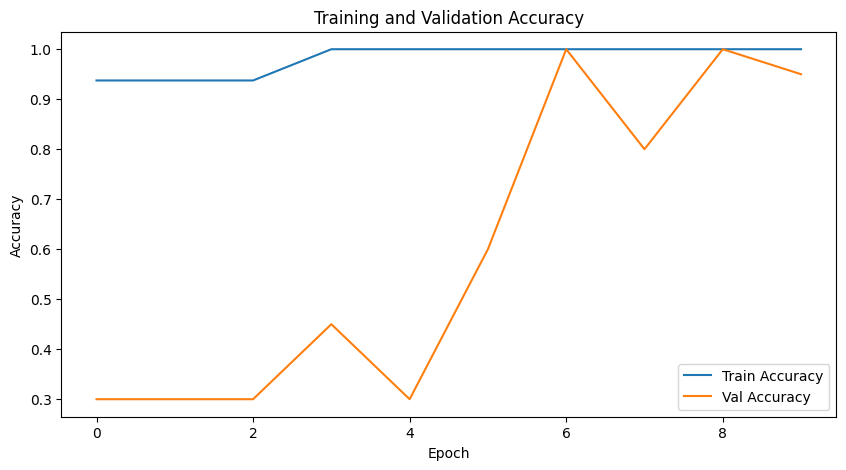

In [12]:

visualize_l_a(train_accuracy, val_accuracy, train_losses, val_losses)

In [13]:
root_folder = '/content/Dataset/xray_dataset_covid19/test'

test_dataset = ImageFolder(root=root_folder, transform=transform)

batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


## Calculate test metrics

In [14]:
def cal_test_metrics(model,test_loader):
  model.eval()

  with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in tqdm(test_loader):
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      predicted=predicted.to('cpu')
      labels=labels.to('cpu')
      y_true.extend(labels.numpy())
      y_pred.extend(predicted.numpy())

  # Generate a classification report
  test_acc = 100*round(correct/total, 4)
  print('accuracy on test data: ', test_acc, '%')

  print(classification_report(y_true, y_pred))
  confusion_matrix((y_true), y_pred)
  disp =ConfusionMatrixDisplay(confusion_matrix((y_true), y_pred))
  disp.plot()
  plt.show()

100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


accuracy on test data:  70.0 %
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        20
           1       1.00      0.40      0.57        20

    accuracy                           0.70        40
   macro avg       0.81      0.70      0.67        40
weighted avg       0.81      0.70      0.67        40



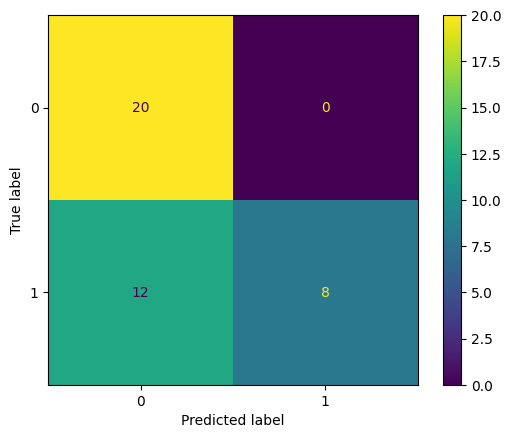

In [15]:
cal_test_metrics(model,test_loader)

## Bonus part

 10%|█         | 1/10 [00:29<04:23, 29.26s/it]

Epoch [1/10],Loss:5.4632,Validation Loss:21.7899,Accuracy:1.00,Validation Accuracy:0.30


 20%|██        | 2/10 [00:56<03:44, 28.01s/it]

Epoch [2/10],Loss:1.6362,Validation Loss:13.6392,Accuracy:1.00,Validation Accuracy:0.30


 30%|███       | 3/10 [01:24<03:15, 27.94s/it]

Epoch [3/10],Loss:1.3759,Validation Loss:5.6096,Accuracy:0.75,Validation Accuracy:0.65


 40%|████      | 4/10 [01:51<02:46, 27.78s/it]

Epoch [4/10],Loss:1.2112,Validation Loss:3.3950,Accuracy:1.00,Validation Accuracy:0.70


 50%|█████     | 5/10 [02:18<02:17, 27.47s/it]

Epoch [5/10],Loss:1.1372,Validation Loss:1.3105,Accuracy:1.00,Validation Accuracy:0.95


 60%|██████    | 6/10 [02:45<01:49, 27.41s/it]

Epoch [6/10],Loss:0.4559,Validation Loss:1.5236,Accuracy:1.00,Validation Accuracy:0.90


 70%|███████   | 7/10 [03:13<01:21, 27.29s/it]

Epoch [7/10],Loss:0.2747,Validation Loss:0.5649,Accuracy:1.00,Validation Accuracy:1.00


 80%|████████  | 8/10 [03:41<00:55, 27.68s/it]

Epoch [8/10],Loss:1.6294,Validation Loss:0.8236,Accuracy:1.00,Validation Accuracy:0.95


 90%|█████████ | 9/10 [04:09<00:27, 27.86s/it]

Epoch [9/10],Loss:0.8205,Validation Loss:1.2271,Accuracy:1.00,Validation Accuracy:0.95


100%|██████████| 10/10 [04:37<00:00, 27.70s/it]

Epoch [10/10],Loss:0.4926,Validation Loss:1.3500,Accuracy:1.00,Validation Accuracy:0.95


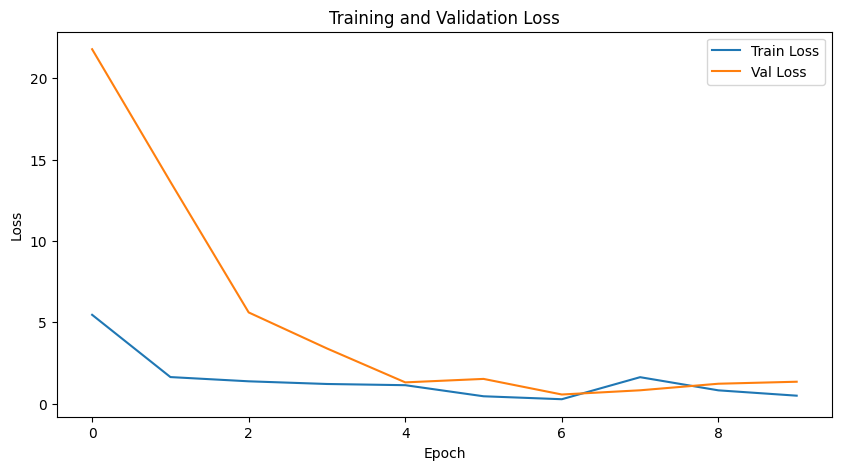

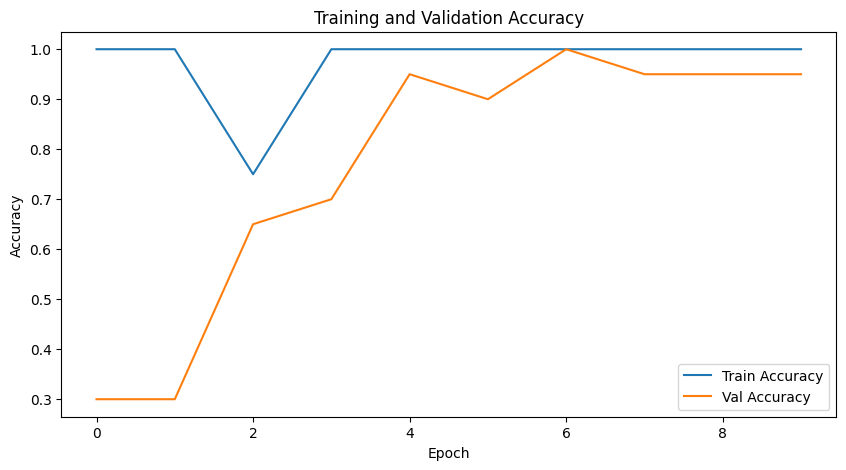

100%|██████████| 2/2 [00:01<00:00,  1.01it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy on test data:  50.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40



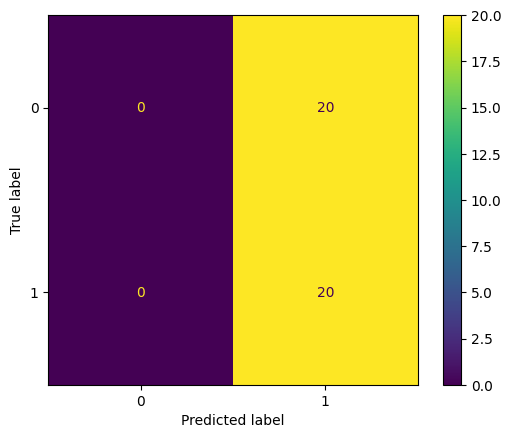

In [19]:
model5 = CNN(num_classes,conv_feat_num=[3,64,64,128,128,256])
model5.to(device)
_, train_accuracy, val_accuracy, train_losses, val_losses=train(model5,train_dataloader,val_dataloader,10,0.0008)
visualize_l_a(train_accuracy, val_accuracy, train_losses, val_losses)
cal_test_metrics(model5,test_loader)

 10%|█         | 1/10 [00:26<04:01, 26.86s/it]

Epoch [1/10],Loss:4.8560,Validation Loss:15.7083,Accuracy:0.94,Validation Accuracy:0.30


 20%|██        | 2/10 [00:54<03:37, 27.21s/it]

Epoch [2/10],Loss:1.2365,Validation Loss:12.4060,Accuracy:1.00,Validation Accuracy:0.30


 30%|███       | 3/10 [01:20<03:08, 26.89s/it]

Epoch [3/10],Loss:0.8418,Validation Loss:2.0729,Accuracy:1.00,Validation Accuracy:0.85


 40%|████      | 4/10 [01:47<02:41, 26.92s/it]

Epoch [4/10],Loss:0.4696,Validation Loss:2.3899,Accuracy:1.00,Validation Accuracy:0.80


 50%|█████     | 5/10 [02:14<02:14, 26.95s/it]

Epoch [5/10],Loss:0.6027,Validation Loss:0.9525,Accuracy:1.00,Validation Accuracy:0.90


 60%|██████    | 6/10 [02:41<01:47, 26.98s/it]

Epoch [6/10],Loss:0.2882,Validation Loss:0.4943,Accuracy:1.00,Validation Accuracy:0.95


 70%|███████   | 7/10 [03:10<01:22, 27.50s/it]

Epoch [7/10],Loss:0.5563,Validation Loss:0.9199,Accuracy:0.88,Validation Accuracy:0.95


 80%|████████  | 8/10 [03:37<00:54, 27.43s/it]

Epoch [8/10],Loss:0.5387,Validation Loss:0.7854,Accuracy:1.00,Validation Accuracy:1.00


 90%|█████████ | 9/10 [04:04<00:27, 27.32s/it]

Epoch [9/10],Loss:0.7304,Validation Loss:1.2076,Accuracy:1.00,Validation Accuracy:0.95


100%|██████████| 10/10 [04:32<00:00, 27.21s/it]

Epoch [10/10],Loss:0.4560,Validation Loss:1.2874,Accuracy:0.88,Validation Accuracy:1.00


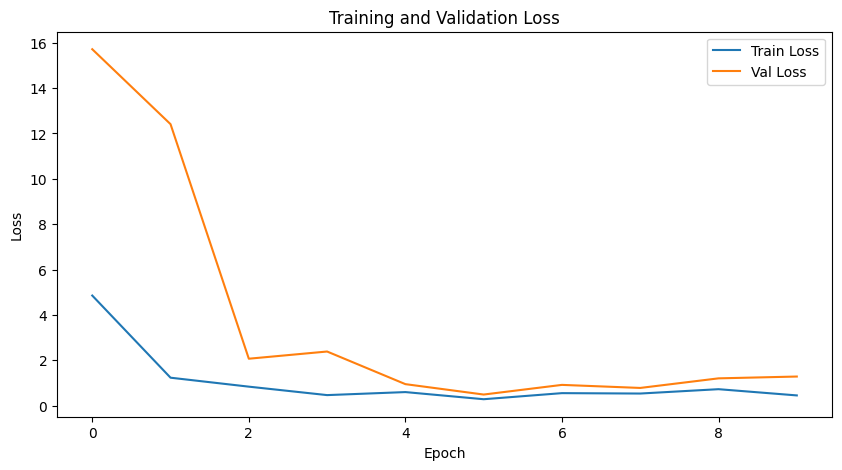

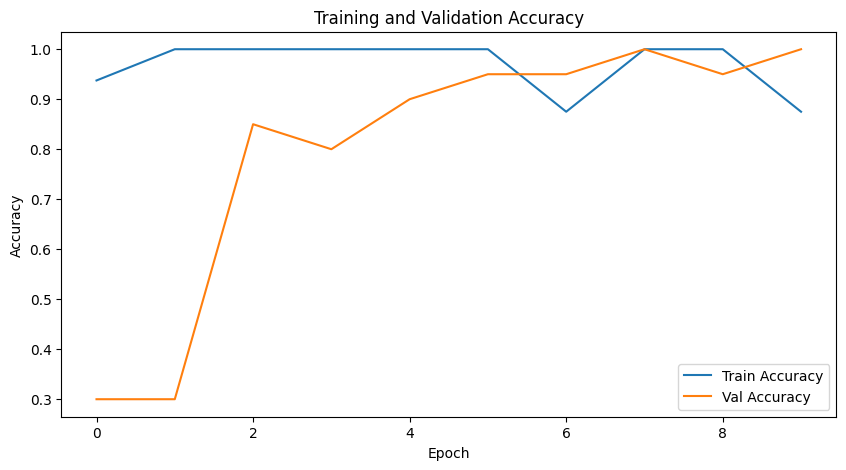

100%|██████████| 2/2 [00:02<00:00,  1.00s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy on test data:  50.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40



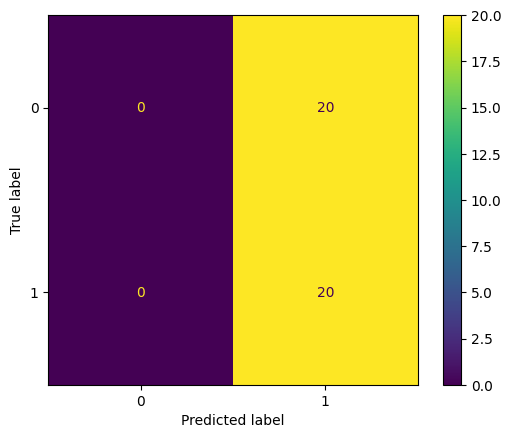

In [20]:
model4 = CNN(num_classes,conv_feat_num=[3,64,64,128,128])
model4.to(device)
_, train_accuracy, val_accuracy, train_losses, val_losses=train(model4,train_dataloader,val_dataloader,10,0.0008)
visualize_l_a(train_accuracy, val_accuracy, train_losses, val_losses)
cal_test_metrics(model4,test_loader)

 10%|█         | 1/10 [00:27<04:07, 27.47s/it]

Epoch [1/10],Loss:4.4340,Validation Loss:16.6610,Accuracy:1.00,Validation Accuracy:0.30


 20%|██        | 2/10 [00:54<03:39, 27.46s/it]

Epoch [2/10],Loss:1.5275,Validation Loss:9.6841,Accuracy:0.94,Validation Accuracy:0.30


 30%|███       | 3/10 [01:22<03:11, 27.29s/it]

Epoch [3/10],Loss:0.6763,Validation Loss:4.7252,Accuracy:1.00,Validation Accuracy:0.55


 40%|████      | 4/10 [01:49<02:43, 27.22s/it]

Epoch [4/10],Loss:0.4662,Validation Loss:0.5561,Accuracy:0.94,Validation Accuracy:0.95


 50%|█████     | 5/10 [02:17<02:17, 27.57s/it]

Epoch [5/10],Loss:0.2918,Validation Loss:0.4773,Accuracy:1.00,Validation Accuracy:0.95


 60%|██████    | 6/10 [02:44<01:49, 27.38s/it]

Epoch [6/10],Loss:0.1446,Validation Loss:0.5165,Accuracy:1.00,Validation Accuracy:1.00


 70%|███████   | 7/10 [03:11<01:21, 27.32s/it]

Epoch [7/10],Loss:0.3792,Validation Loss:0.6177,Accuracy:0.94,Validation Accuracy:0.90


 80%|████████  | 8/10 [03:38<00:54, 27.27s/it]

Epoch [8/10],Loss:0.4211,Validation Loss:0.3024,Accuracy:0.94,Validation Accuracy:1.00


 90%|█████████ | 9/10 [04:06<00:27, 27.48s/it]

Epoch [9/10],Loss:0.5480,Validation Loss:0.7226,Accuracy:1.00,Validation Accuracy:0.95


100%|██████████| 10/10 [04:34<00:00, 27.48s/it]

Epoch [10/10],Loss:0.1965,Validation Loss:0.6570,Accuracy:1.00,Validation Accuracy:1.00


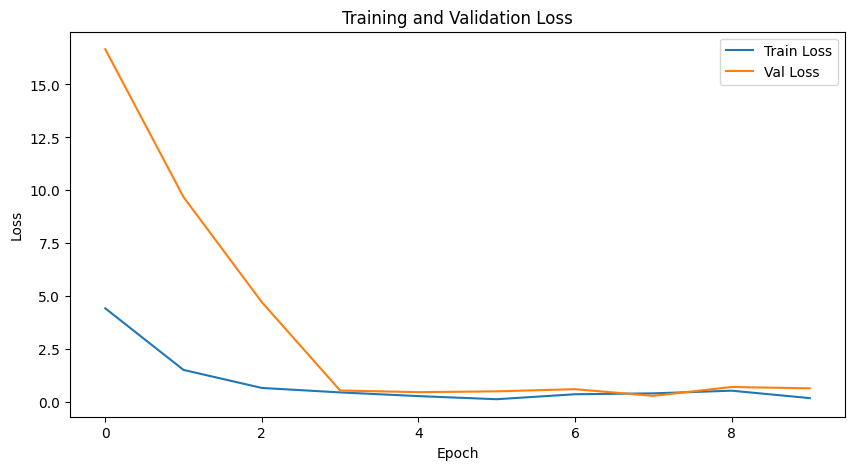

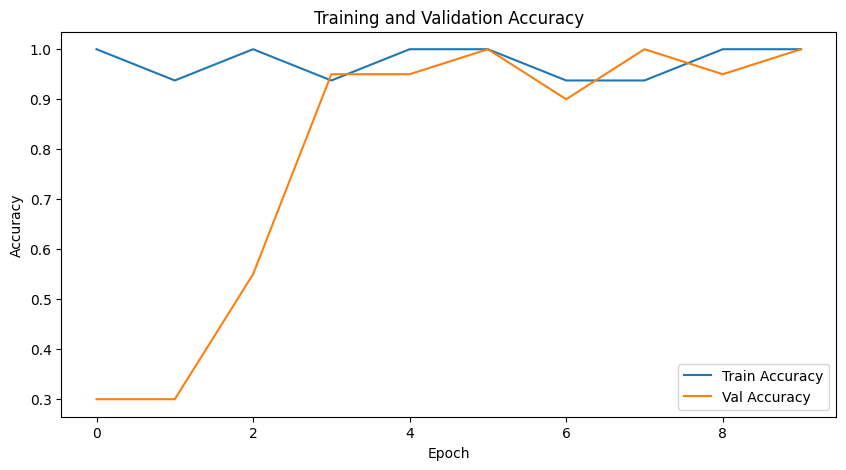

100%|██████████| 2/2 [00:01<00:00,  1.82it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy on test data:  50.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40



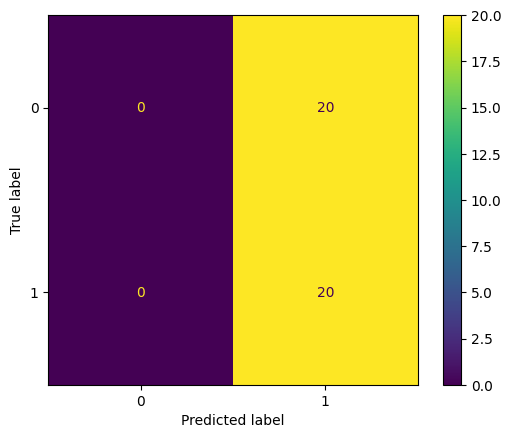

In [21]:
model3 = CNN(num_classes,conv_feat_num=[3,64,64,128])
model3.to(device)
_, train_accuracy, val_accuracy, train_losses, val_losses=train(model3,train_dataloader,val_dataloader,10,0.0008)
visualize_l_a(train_accuracy, val_accuracy, train_losses, val_losses)
cal_test_metrics(model3,test_loader)

 10%|█         | 1/10 [00:27<04:04, 27.17s/it]

Epoch [1/10],Loss:5.9165,Validation Loss:5.3079,Accuracy:0.88,Validation Accuracy:0.45


 20%|██        | 2/10 [00:54<03:37, 27.17s/it]

Epoch [2/10],Loss:1.5830,Validation Loss:4.0221,Accuracy:1.00,Validation Accuracy:0.50


 30%|███       | 3/10 [01:22<03:12, 27.47s/it]

Epoch [3/10],Loss:0.6085,Validation Loss:0.9296,Accuracy:1.00,Validation Accuracy:0.90


 40%|████      | 4/10 [01:49<02:43, 27.26s/it]

Epoch [4/10],Loss:0.6952,Validation Loss:0.4162,Accuracy:0.94,Validation Accuracy:0.95


 50%|█████     | 5/10 [02:15<02:15, 27.06s/it]

Epoch [5/10],Loss:0.3865,Validation Loss:0.4556,Accuracy:1.00,Validation Accuracy:1.00


 60%|██████    | 6/10 [02:42<01:48, 27.07s/it]

Epoch [6/10],Loss:0.2288,Validation Loss:0.5711,Accuracy:1.00,Validation Accuracy:1.00


 70%|███████   | 7/10 [03:09<01:20, 26.98s/it]

Epoch [7/10],Loss:0.1481,Validation Loss:0.2409,Accuracy:1.00,Validation Accuracy:1.00


 80%|████████  | 8/10 [03:37<00:54, 27.17s/it]

Epoch [8/10],Loss:0.1845,Validation Loss:0.5773,Accuracy:1.00,Validation Accuracy:1.00


 90%|█████████ | 9/10 [04:06<00:27, 27.74s/it]

Epoch [9/10],Loss:0.3653,Validation Loss:0.5086,Accuracy:1.00,Validation Accuracy:0.95


100%|██████████| 10/10 [04:33<00:00, 27.34s/it]

Epoch [10/10],Loss:0.1817,Validation Loss:0.6155,Accuracy:1.00,Validation Accuracy:0.95


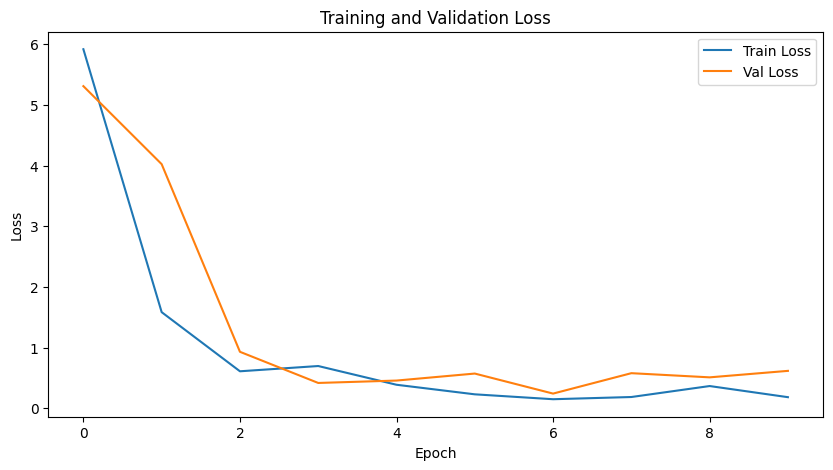

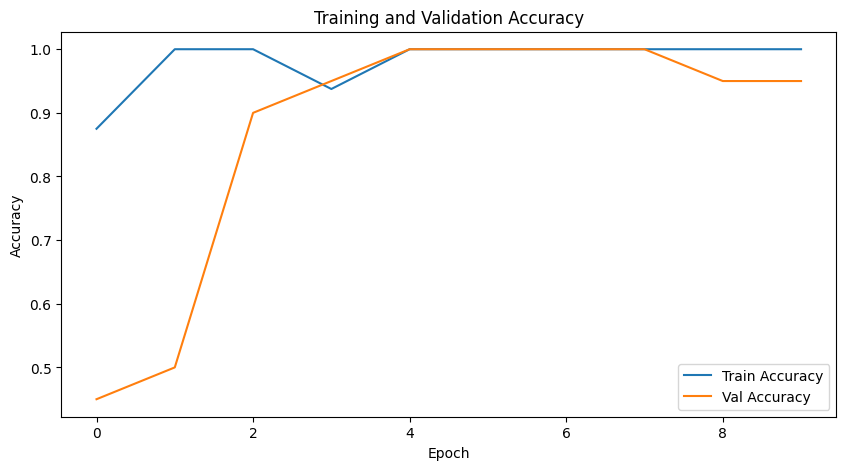

100%|██████████| 2/2 [00:01<00:00,  1.83it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy on test data:  50.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40



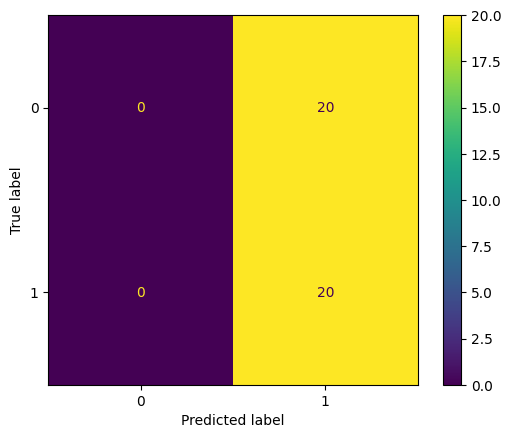

In [22]:
model2 = CNN(num_classes,conv_feat_num=[3,64,64])
model2.to(device)
_, train_accuracy, val_accuracy, train_losses, val_losses=train(model2,train_dataloader,val_dataloader,10,0.0008)
visualize_l_a(train_accuracy, val_accuracy, train_losses, val_losses)
cal_test_metrics(model2,test_loader)

 10%|█         | 1/10 [00:27<04:09, 27.77s/it]

Epoch [1/10],Loss:6.8645,Validation Loss:2.1628,Accuracy:0.88,Validation Accuracy:0.70


 20%|██        | 2/10 [00:54<03:39, 27.45s/it]

Epoch [2/10],Loss:2.8268,Validation Loss:1.4318,Accuracy:1.00,Validation Accuracy:0.85


 30%|███       | 3/10 [01:21<03:10, 27.16s/it]

Epoch [3/10],Loss:1.3622,Validation Loss:0.6746,Accuracy:1.00,Validation Accuracy:0.95


 40%|████      | 4/10 [01:48<02:42, 27.08s/it]

Epoch [4/10],Loss:1.0528,Validation Loss:0.4166,Accuracy:1.00,Validation Accuracy:0.95


 50%|█████     | 5/10 [02:15<02:14, 26.96s/it]

Epoch [5/10],Loss:0.2610,Validation Loss:0.2408,Accuracy:1.00,Validation Accuracy:1.00


 60%|██████    | 6/10 [02:41<01:46, 26.73s/it]

Epoch [6/10],Loss:0.3160,Validation Loss:0.3431,Accuracy:0.94,Validation Accuracy:1.00


 70%|███████   | 7/10 [03:08<01:20, 26.67s/it]

Epoch [7/10],Loss:0.3835,Validation Loss:0.2583,Accuracy:1.00,Validation Accuracy:1.00


 80%|████████  | 8/10 [03:36<00:54, 27.13s/it]

Epoch [8/10],Loss:0.1847,Validation Loss:0.3391,Accuracy:1.00,Validation Accuracy:1.00


 90%|█████████ | 9/10 [04:03<00:27, 27.08s/it]

Epoch [9/10],Loss:0.0926,Validation Loss:0.4763,Accuracy:1.00,Validation Accuracy:1.00


100%|██████████| 10/10 [04:31<00:00, 27.11s/it]

Epoch [10/10],Loss:0.0518,Validation Loss:0.3676,Accuracy:1.00,Validation Accuracy:1.00


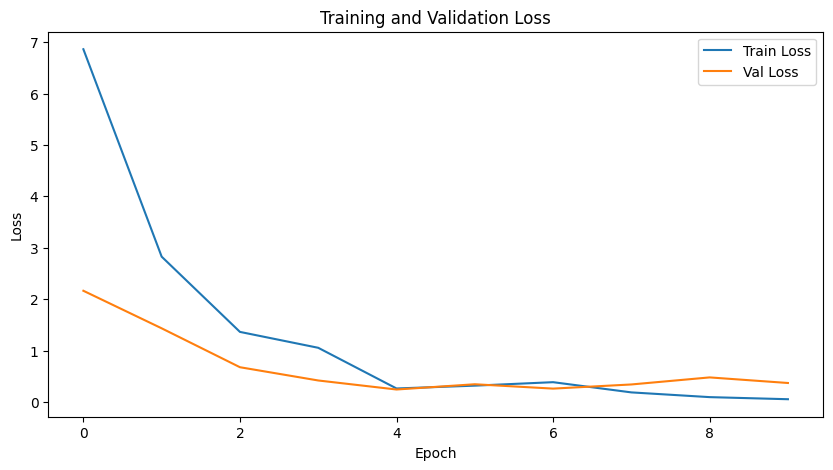

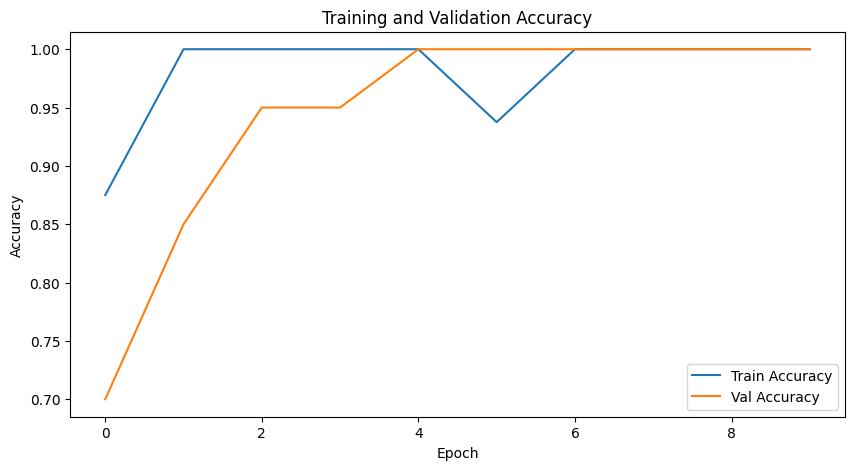

100%|██████████| 2/2 [00:01<00:00,  1.22it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy on test data:  50.0 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40



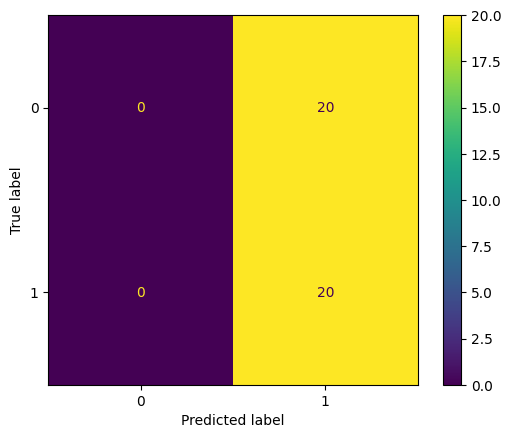

In [23]:
model1 = CNN(num_classes,conv_feat_num=[3,64])
model1.to(device)
_, train_accuracy, val_accuracy, train_losses, val_losses=train(model1,train_dataloader,val_dataloader,10,0.0008)
visualize_l_a(train_accuracy, val_accuracy, train_losses, val_losses)
cal_test_metrics(model1,test_loader)